<h1>Creating OSM Completeness Model</h1>

<p>This Jupyter notebook takes as input training polygons produced from the <a href="https://observablehq.com/@jobelanger/osm-training-set-creation-nepal-example">Mapbox OSM Training Set Creation</a> Observable notebook. To use this notebook, you'll also need to sign up for a <a href="https://earthengine.google.com/new_signup/"> Google Earth Engine Account</a>.</p>

In [1]:
import seaborn as sns
import geojson
import json
# in windows, there may be an issue importing geopandas. follow nlt completeness readme from github to change rtree's core.py
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, box, mapping, Point, Polygon
import numpy as np
import osmnx as ox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import math
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils
import gdal, gdalconst
from scipy.cluster.vq import kmeans2

In [2]:
# authenticate account using google earth engine
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/4gFbR1TYncDnAhmueyEbxUY3ngasot_lAc5E5GjR-lt1tWmH9t_VYko

Successfully saved authorization token.


<h2>These are all variables that need to be set before running the notebook</h2>
<p>Download <a href ="https://data.humdata.org/search?organization=facebook&q=high%20resolution%20population&ext_page_size=25&sort=score%20desc%2C%20if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc">Facebook population data</a> and/or <a href="https://www.worldpop.org/geodata/listing?id=29">WorldPop</a> data for your area of interest and insert the paths into the cell below. Facebook data is not available for every country, and the World Settlement Footprint (WSF) dataset is not publicly available. If not available, references to those datasets will have to be commented out.</p>

In [6]:
#change this file path to the location of the json data downloaded from the OSM Training Set Observable notebook
trainingJSON = Features("P:\AFG\GEO\Team\Projects\OSM_Completeness\Jo_Testing\inputs_20200907\outputCellsJSON_afg_602.json")

#Facebook and WorldPop data paths
#fbPath = "path_to_fb_raster"
wpPath = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\Jo_Testing\inputs_20200907\afg_ppp_2020.tif"

# global urban footprint path
gufPath = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\Jo_Testing\inputs_20200907\Afghanistan04.tif"

# global landcover path
glcPath = "P:\AFG\GEO\Team\Projects\OSM_Completeness\Jo_Testing\inputs_20200907\glc_shv10_01.Tif"

#define location to save trained model
filename = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\Jo_Testing\Default_602\afg_rf_model_default_602.sav"

In [4]:
#class for GeoJSON feature collections. To complete analysis need two:
#1. training data from Observable notebook
#2. grid data that wil be run through trained model and output
class Features:
    
    def __init__(self, filename=''):
        self.filename = filename
        self.polygons = []
        
        if filename=='':
            return
        
        with open(filename) as f:
            self.data = json.load(f)
        try:
            self.features = self.data['features']
        except:
            print("JSON file did not have features array")
            
    def getPolygons(self):
        for feature in self.features:
            g = shape(feature['geometry']).buffer(0)
            self.polygons.append(g)
        print(len(self.polygons))
        return self.polygons
    
    #used if creating own grid, not reading JSON file in __init__
    def setData(self, df):
        self.data = mapping(df.geometry)
        #don't need bbox for anything so delete it to reduce output file size
        del self.data['bbox']
        for feature in self.data['features']:
            del feature['bbox']
        self.features = self.data['features']
    
    def projectGeoDataFrame(self, *args):
        if len(args) > 0:
            df = args[0]
        else:
            df = self.geoDataFrame
        
        avg_longitude = (self.bounds[0] + self.bounds[2])/2
        utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
        utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
   
        # project the GeoDataFrame to the UTM CRS
        self.geoDataFrameProjected = df.to_crs(utm_crs)
        
        return self.geoDataFrameProjected
    
    def createGeoDataFrame(self):
        self.geoDataFrame = gpd.GeoDataFrame({
            'geometry': self.polygons
        })
        self.geoDataFrame.crs = "EPSG:4326"
        return self.geoDataFrame
        
    def getBounds(self):
        self.bounds = self.geoDataFrame.total_bounds
        return self.bounds
    
    def getClippingBox(self):
        if not hasattr(self, 'bounds'):
            self.getBounds()
        bbox = box(self.bounds[0], self.bounds[1], self.bounds[2], self.bounds[3])
        self.bbox = bbox
        self.clippingBox = {'type': 'Feature', 'properties': {}, 'geometry': mapping(bbox)}
        return self.clippingBox

In [7]:
#class to work with tiff datasets
class Raster:
    
    def __init__(self, filename):
        self.filename = filename
        
    def dataFromBounds(self, band, bounds):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            window = rasterio.windows.from_bounds(bounds[0],bounds[1],bounds[2],bounds[3], src.transform)
            self.boundsData = src.read(band, window=window)
            self.boundsTransform = src.window_transform(window)

<p>The series of cells containing functions beginning with <b>ee</b> use the Google Earth Engine API</p>

In [8]:
def eeForest(features):
    ee.Initialize()
    gfcImage = ee.Image("UMD/hansen/global_forest_change_2018_v1_6")
    FCL0018 = gfcImage.select(['loss']).eq(1).rename('fcloss0018')
    FC00 = gfcImage.select(['treecover2000']).gte(20)
    FC18 = FC00.subtract(FCL0018).rename('FC18')
    FC18Area = FC18.multiply(ee.Image.pixelArea()).rename('FC18Area')
    forestSum = FC18Area.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return forestSum.getInfo()

In [9]:
def eeTexture(features, JSONob):
    ee.Initialize()
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(JSONob.clippingBox['geometry']).filterMetadata('instrumentMode', 'equals', 'IW')
    .select(['VV', 'angle']))

    se1 = s1.select(0).filterDate('2019-01-01', '2019-07-31').median()

    textureMean = se1.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 10
        #maxPixels= 1e9
    )
    return textureMean.getInfo()

In [10]:
def eeSlope(features):
    ee.Initialize()
    srtm = ee.Image("CSP/ERGo/1_0/Global/SRTM_mTPI")
    slope = ee.Terrain.slope(srtm).rename('slope')
    slopeMean = slope.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 270
        #maxPixels= 1e9
    )
    return slopeMean.getInfo()

In [11]:
#only return 2019 
def eeVIIRSNTL(features):
    ee.Initialize()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

    #2019 viirs
    viirs_2019_mean = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').mean().rename('viirs_2019_mean')
    viirs_2019_median = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').median().rename('viirs_2019_median')
    viirs_2019_max = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').max().rename('viirs_2019_max')

    VIIRS2019 = viirs_2019_mean.addBands(viirs_2019_median).addBands(viirs_2019_max)

    stats2019 = VIIRS2019.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return stats2019.getInfo()

In [12]:
def eeIndices(features, JSONob):
   
    ee.Initialize()
    #Map the function over one year of data and take the median.
    #Load Sentinel-2 TOA reflectance data.
    collection = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2019-01-01', '2020-07-31')
        #Pre-filter to get less cloudy granules.
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))

    composite = collection.median().clip(ee.Feature(JSONob.clippingBox))#.int()  
    ndbi = composite.normalizedDifference(['B11','B8']).rename('ndbi')
    ndvi = composite.normalizedDifference(['B8','B4']).rename('ndvi')
    savi = composite.expression(
        '1.5 * (NIR-RED) / (NIR+RED+0.5)', {
          'NIR': composite.select('B8'),
          'RED': composite.select('B4')
    }).rename('savi').float()
    urbanIndex = composite.normalizedDifference(['B12','B8']).rename('ui')
    sen2AllIndices = ndvi.addBands(ndbi).addBands(savi).addBands(urbanIndex)
    #Calculate Indices
    finalIndices = sen2AllIndices.reduceRegions(
    collection= ee.FeatureCollection(features),
    reducer= ee.Reducer.sum(),
    scale= 10,
    )
    return finalIndices.getInfo()

### calculate zonal stats on the training data

In [13]:
#function to load a raster and perform a zonal statistic over a set of polygons
#polys = list of polygons to perform stats over
#stat = string denoting which statistic to calculate
#path = raster file path
#nodata = raster value that should be treated as no data
def zonalStats(polys, stat, path, nodata):
    raster = rasterio.open(path)
    trans = raster.transform
    band = raster.read(1)
    stats = zonal_stats(polys, band, affine = trans, stats=[stat], nodata=nodata)
    toAdd = [x[stat] for x in stats]
    #free memory
    band = []
    return toAdd

In [14]:
#return area of building footprints in cell
def returnClippedArea(spatialIndex, buildingDF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = buildingDF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.area).sum()

In [15]:
#return length of line in grid cell (clippingPoly)
def returnClippedLength(spatialIndex, DF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = DF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.length).sum()

In [16]:
#return number of road intersections in grid cell
def returnClippedPoints(spatialIndex, DF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = DF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return len(preciseClip.index)

<h2>Calculating features over training polygons</h2>

In [17]:
###############################################
# processing training data JSON
###############################################

#order these 6 lines are called is important
trainingPolys = trainingJSON.getPolygons()
trainingDF = trainingJSON.createGeoDataFrame()
trainingFeatures = trainingJSON.features
trainingBounds = trainingJSON.getBounds()
trainingClip = trainingJSON.getClippingBox()
trainingDFProjected = trainingJSON.projectGeoDataFrame(trainingDF)

#trainingPopToAddFB = zonalStats(trainingPolys, 'sum', fbPath, np.nan)
#print("done fb")
trainingPopToAddWP = zonalStats(trainingPolys, 'sum', wpPath, -99999.0)
print("done wp")
trainingPopToAddGUF = zonalStats(trainingPolys, 'count', gufPath, 0)
print("done guf")
trainingPopToAddGLC = zonalStats(trainingPolys, 'mean', glcPath, 0)
print("done glc")

print("done training ingest and population")

602
done wp
done guf
done glc
done training ingest and population


<h3>Downloading building footprints</h3>
<p>The purpose of this cell is to download OSM building footprints. The code clusters the training samples and calculates the convex hull for each cluster. It then downloads the footprints in each hull. The purpose of this approach is to avoid downloading large amounts of building footprints that are not needed. For example, if you collected samples in the northwest portion of a country and the southeast portion of a country then used the bounding box of all samples to determine the OSM data downloaded, you would be downloading data for the entire country. In that same situation, k-means clustering with 2 clusters should download footprints for each cluster only.</p>

<p>To create two clusters change the kmeans2 line to:</p>

`centroid, label = kmeans2(centroids, 2, minit='++')`

In [18]:
#get centroid of each cell
trainingDF["centroid"] = trainingDF.centroid

#get centroids in x,y form
centroids = []
for p in trainingDF.centroid:
    centroids.append([p.x,p.y])
    
#k means cluster so that we don't grab buildings over a larger
#area than needed later. This creates 10 clusters
centroid, label = kmeans2(centroids, 2, minit='++')

centroidIdxs = list(set(label))

trainingDF["label"] = label
trainingAreas = []
oIndices = []

#loop through each cluster
for idx in centroidIdxs:
    print(idx)
    subdf = trainingDF.loc[trainingDF['label'] == idx]
    print(len(subdf.index))
    #convex hull of cluster
    subHullPoly = subdf.unary_union.convex_hull
    #downloading data using convex hull as polygon boundary
    subTrainingFootprints = ox.footprints_from_polygon(subHullPoly)
    subBounds = subdf.total_bounds
    #convert to UTM for accurate area calculations
    avg_longitude = (subBounds[0] + subBounds[2])/2
    utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
    utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
    print("projecting")
    subdfProjected = subdf.to_crs(utm_crs)
    subTrainingFootprintsProjected = subTrainingFootprints.to_crs(utm_crs)
    subTrainingFootprintsSindex = subTrainingFootprintsProjected.sindex
    #loop through cell polygons
    for i,row in subdfProjected.iterrows():
        oIndices.append(i)
        trainingAreas.append(returnClippedArea(subTrainingFootprintsSindex, subTrainingFootprintsProjected, row.geometry))
#should be equal to number of training polygons        
print(len(oIndices))
print(len(trainingAreas))
areasDF = pd.DataFrame.from_dict({
    "index":oIndices,
    "area":trainingAreas
})

#merge dataframes back together to align areas with original dataframe
trainingDF2 = pd.merge(areasDF, trainingDF, right_index=True, left_on='index')
trainingDF2 = trainingDF2.sort_values('index')
trainingAreas = trainingDF2['area']

0
111
projecting
1
491
projecting
602
602


In [19]:
#google earth engine can only process 5000 features at a time. Split into 4000 feature chunks to be safe and avoid errors
#I have still occasionally received errors with 4000. In that case I just keep lowering by 500 until the errors go away
trainingFeatures = trainingJSON.features
nFeatures = len(trainingFeatures)
batchSize = 4000
nCalcs = int(math.floor(nFeatures/batchSize) + 1)

sections = list(range(0,batchSize*nCalcs,batchSize))

In [20]:
#trainingForestJSON = eeForest(trainingFeatures)
#print("done training forest")

for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = trainingFeatures[section::]
    else:
        toProcess = trainingFeatures[section:section+batchSize]
        
    if section == 0:
        trainingForestJSON = eeForest(toProcess)
    else:
        trainingForestJSON['features'] = trainingForestJSON['features'] + eeForest(toProcess)['features']

print(len(trainingForestJSON['features']))
print("done training forest")

0
602
done training forest


In [21]:
#trainingTextureJSON = eeTexture(trainingFeatures, trainingJSON)
#print("done training texture")

for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = trainingFeatures[section::]
    else:
        toProcess = trainingFeatures[section:section+batchSize]
        
    if section == 0:
        trainingTextureJSON = eeTexture(toProcess, trainingJSON)
    else:
        trainingTextureJSON['features'] = trainingTextureJSON['features'] + eeTexture(toProcess, trainingJSON)['features']

print(len(trainingTextureJSON['features']))
print("done training texture")

0
602
done training texture


In [22]:
#trainingSlopeJSON = eeSlope(trainingFeatures)
#print("done training slope")

for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = trainingFeatures[section::]
    else:
        toProcess = trainingFeatures[section:section+batchSize]
        
    if section == 0:
        trainingSlopeJSON = eeSlope(toProcess)
    else:
        trainingSlopeJSON['features'] = trainingSlopeJSON['features'] + eeSlope(toProcess)['features']

print(len(trainingSlopeJSON['features']))
print("done training slope")

0
602
done training slope


In [23]:
#trainingVIIRS2019JSON = eeVIIRSNTL(trainingFeatures)
#print("done training VIIRS NTL")

for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = trainingFeatures[section::]
    else:
        toProcess = trainingFeatures[section:section+batchSize]
        
    if section == 0:
        trainingVIIRS2019JSON = eeVIIRSNTL(toProcess)
    else:
        trainingVIIRS2019JSON['features'] = trainingVIIRS2019JSON['features'] + eeVIIRSNTL(toProcess)['features']

print(len(trainingVIIRS2019JSON['features']))
print("done training VIIRS NTL")

0
602
done training VIIRS NTL


In [24]:
#trainingIndicesJSON = eeIndices(trainingFeatures, trainingJSON)
#print("done training indices")

for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = trainingFeatures[section::]
    else:
        toProcess = trainingFeatures[section:section+batchSize]
        
    if section == 0:
        trainingIndicesJSON = eeIndices(toProcess, trainingJSON)
    else:
        trainingIndicesJSON['features'] = trainingIndicesJSON['features'] + eeIndices(toProcess, trainingJSON)['features']

print(len(trainingIndicesJSON['features']))
print("done training indices")

0
602
done training indices


In [25]:
#helper function to get values from objects returned from earth engine
def returnFeatureVals(featureString, variable):
    return [x['properties'][featureString] for x in variable['features']]

In [26]:
trainingFeatureDict = {
    'ndbi':returnFeatureVals('ndbi', trainingIndicesJSON),
    'ndvi':returnFeatureVals('ndvi', trainingIndicesJSON),
    'savi':returnFeatureVals('savi', trainingIndicesJSON),
    'ui':returnFeatureVals('ui', trainingIndicesJSON),
    'viirs':returnFeatureVals('viirs_2019_max', trainingVIIRS2019JSON),
    'slope':returnFeatureVals('mean', trainingSlopeJSON),
    'texture':returnFeatureVals('mean', trainingTextureJSON),
    'forest':returnFeatureVals('sum', trainingForestJSON),
    'popWP':trainingPopToAddWP,
    'popGUF':trainingPopToAddGUF,
    'popGLC':trainingPopToAddGLC,
    'area':trainingAreas
}

trainingDF = pd.DataFrame.from_dict(trainingFeatureDict)
trainingGeoDF = gpd.GeoDataFrame(trainingDF,crs = 4326, geometry=trainingJSON.polygons)
trainingGeoDF = trainingGeoDF.fillna(0)

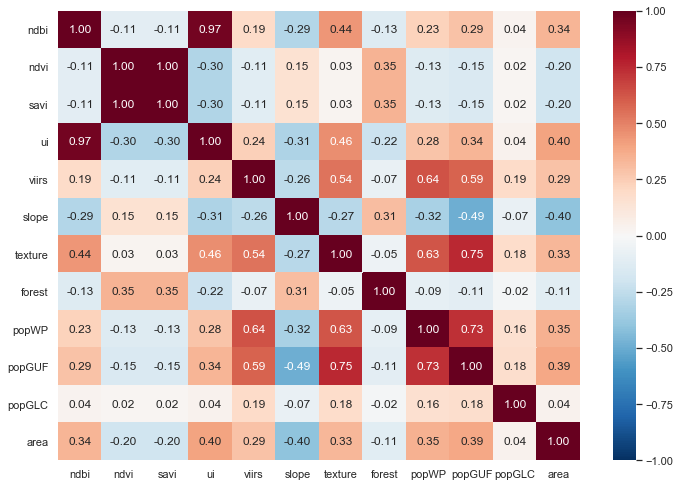

In [27]:
#plot correlation matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(trainingGeoDF.corr(), annot=True, fmt=".2f",cmap='RdBu_r', center=0, vmin=-1, vmax=1)

In [28]:
trainingFeatureDF = trainingGeoDF[['ndbi','ndvi','savi','ui','viirs','slope','texture','forest','popWP','popGUF', 'popGLC']]
trainingTargetDF = trainingGeoDF['area']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(trainingFeatureDF, trainingTargetDF, test_size=0.3, random_state=42)

#### default fit

0.5743045605620736
6770.315293738343


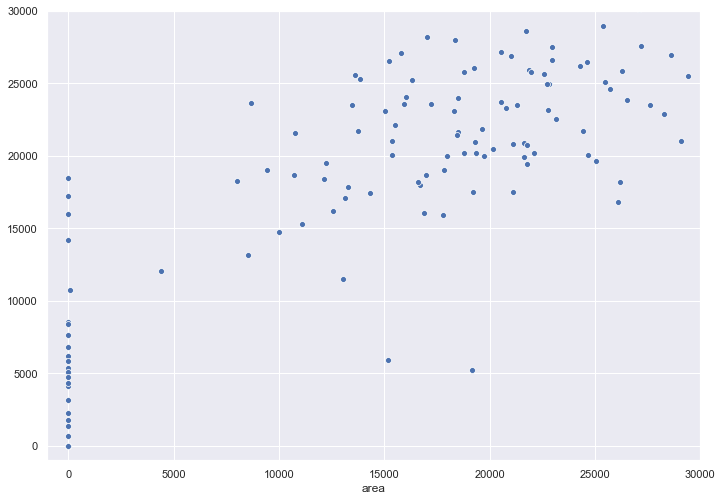

In [30]:
#fit with default settings for reference (70/30 training/test split, no cross validation)
RandomForest = RandomForestRegressor()
RandomForest.fit(X_train, y_train)
y_pred = RandomForest.predict(X_test)
print(r2_score(y_test,y_pred))
ax1 = sns.scatterplot(x=y_test,y=y_pred)
ax1.set(ylim=(-1000, 30000))
ax1.set(xlim=(-1000, 30000))
print(mean_absolute_error(y_test,y_pred))

In [32]:
#fit with optimized settings (takes a few minutes)

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

#### optimized fit

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
0.610757773466666
6610.414960070234


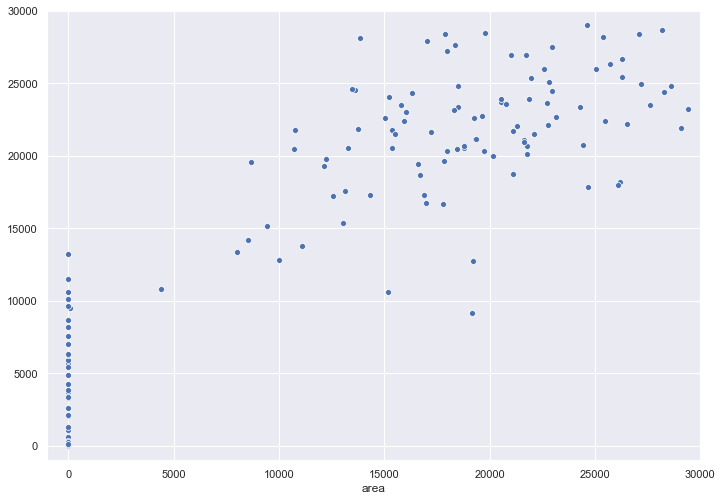

In [33]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)
print(r2_score(y_test,y_pred))
ax = sns.scatterplot(x=y_test,y=y_pred)
ax.set(ylim=(-1000, 30000))
ax.set(xlim=(-1000, 30000))
print(mean_absolute_error(y_test,y_pred))

In [34]:
import joblib

joblib.dump(best_random, filename)

['P:\\AFG\\GEO\\Team\\Projects\\OSM_Completeness\\Jo_Testing\\Default_602\\afg_rf_model_default_602.sav']